# Toward an AFL Tipping Model, part 1: An Analysis of Basic Heuristics

## Comparison of Accuracies of Basic Heuristics

Footy tipping is the popular Australian pasttime of picking which teams will win their matches every week (like filling out a March Madness bracket, except it's done a round at a time, and everyone drops their 'r's). At the end of the season, the group of competitors will add up the number of matches that they predicted correctly, with the winner usually walking away with a pot of money.

There are a variety of heuristics that one could use to pick the winners and losers for the week. In my conversations with other tippers, I've found that the average perticipant tends to take in data such as which team is favoured, which is the home team, how well each team has been playing lately, and whom they expect fellow competitors to tip, then process the input in their gut, which produces the predicted result.

Below, I will present a few naive heuristics for predicting match results and compare their respective accuracies.

In [1]:
# Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(42)

In [2]:
# Load data

# Get cumulative stats by team & year, then shift by team to carry over end of last season for first round rankings
def team_year_cum_col(df, stat_label):
    return (df.groupby(level=[0, 1])
              [stat_label]
              .cumsum()
              .groupby(level=[0])
              .shift()
              .fillna(0))

df = pd.read_csv('../data/full_data.csv')
# Betting data only goes back to 2010, so dropping earlier years for consistency
df = (df[(df['year'] >= 2010)]
        # Note that bye weeks and seasons before newer teams existed mark most stats as 0,
        # including the opposing team's name
        .assign(draw=((df['score'] == df['oppo_score']) & (df['oppo_team'] != '0')).astype('int'))
        .fillna(0)
        .set_index(['team', 'year', 'round_number'], drop=False)
        .sort_index())

# Calculate cumulative stats by team & year
df.loc[:, 'cum_score'] = team_year_cum_col(df, 'score')
df.loc[:, 'cum_oppo_score'] = team_year_cum_col(df, 'oppo_score')
df.loc[:, 'cum_percent'] = df['cum_score'] / df['cum_oppo_score']
# For ladder rank, wins give a team 4 points; draws give both teams 2 points
df.loc[:, 'cum_win_points'] = (((df.groupby(level=[0, 1])['win'].cumsum() * 4) +
                                (df.groupby(level=[0, 1])['draw'].cumsum() * 2))
                               .groupby(level=[0])
                               .shift()
                               .fillna(0))

# Pivot to get round-by-round match points and cumulative percent
ladder_pivot_table = (df.loc[:, ['cum_win_points', 'cum_percent']]
                        .pivot_table(index=['year', 'round_number'],
                                     values=['cum_win_points', 'cum_percent'],
                                     columns='team',
                                     aggfunc={'cum_win_points': np.sum, 'cum_percent': np.mean}))

# Sort each round by points & percent, then save rank numbers
ladder_index = []
ladder_values = []

for idx, row in ladder_pivot_table.iterrows():
    sorted_row = (row.unstack(level=0)
                     .sort_values(['cum_win_points', 'cum_percent'], ascending=False))
    ladder_ranks = np.array(range(len(sorted_row)))
    
    
    for ladder_idx, team_name in enumerate(sorted_row.index.get_values()):
        ladder_index.append(tuple([team_name, *idx]))
        ladder_values.append(ladder_idx + 1)
        
ladder_ranks = pd.Series(ladder_values,
                         index=pd.MultiIndex.from_tuples(ladder_index, names=('team', 'year', 'round_number')),
                         name='ladder_rank')

# Add ladder_rank to df
df = pd.concat([df, ladder_ranks], axis=1)

# Get opponent's ladder rank
oppo_team_ladder = (df[df['oppo_team'] != '0']
                      .loc[:, ['oppo_team', 'ladder_rank']]
                      .reset_index()
                      .drop('team', axis=1)
                      .rename(columns={'ladder_rank': 'oppo_ladder_rank', 'oppo_team': 'team'})
                      .set_index(['team', 'year', 'round_number'])
                      .sort_index())

# Add oppo_ladder_rank to ladder_df
df = pd.concat([df, oppo_team_ladder], axis=1).fillna(0)

df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                      23                  0.0                  0.0   
                      24                  0.0                  0.0   
                 2011 1                   1.0                  0.0   
                      2                   0.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                      24                  0.0                  0.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      11                  0.0                  0.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0                  4.0   
                      19                  1.0 

In [ ]:
def correct_tip(df):
    # Draws give all tippers a win
    return ((df['win'] == df['pred_win']) | (df['draw'] == 1)).astype('int')

In [3]:
# Always tip the home team

# Filter out bye weeks
home_df = (df[df['oppo_team'] != '0'].assign(pred_win=df['home_team']))
home_df.loc[:, 'correct_tip'] = correct_tip(home_df)
home_accuracy = home_df['correct_tip'].mean()

print('Always Tip Home Team Accuracy: {0:.2f}%'.format(home_accuracy * 100))

Always Tip Home Team Accuracy: 57.29%


In [5]:
# Always tip the higher-ranked team

ladder_df = df[df['oppo_team'] != '0'].copy()

# Filter out byes for predictions and accuracy calculations
ladder_df.loc[:, 'pred_win'] = (ladder_df['ladder_rank'] < ladder_df['oppo_ladder_rank']).astype('int')
# Draws give all tippers a win
ladder_df.loc[:, 'correct_tip'] = correct_tip(ladder_df)
ladder_accuracy = ladder_df['correct_tip'].mean()

print('Always Tip Higher Ranked Accuracy: {0:.2f}%'.format(ladder_accuracy * 100))

Always Tip Higher Ranked Accuracy: 67.58%


In [4]:
# Always tip the betting-odds favourite

# Negative point spread indicates the favourite
def betting_pred_win(df):
    # point_spread == 0 means it's a coin flip
    return (((match_df['point_spread'] < 0) | ((match_df['point_spread'] == 0) & (np.random.rand() >= 0.5)))
            .astype('int'))
    
def point_spread_predictions(df):
    return df['point_spread'].apply(point_spread_prediction)

# Filter out bye weeks
favourite_df = (df[df['oppo_team'] != '0'].assign(pred_win=betting_pred_win))
# Draws give all tippers a win
favourite_df.loc[:, 'correct_tip'] = correct_tip(favourite_df)
favourite_accuracy = favourite_df['correct_tip'].mean()

print('Always Tip Favourite Accuracy: {0:.2f}%'.format(favourite_accuracy * 100))

Always Tip Favourite Accuracy: 72.42%


In [6]:
# Combine all 3 heuristics via voting

voting_df = pd.concat([home_df['pred_win'], favourite_df['pred_win'], ladder_df['pred_win'], df[['win', 'draw']]],
                      axis=1)
voting_df.columns = ['home_pred', 'favourite_pred', 'ladder_pred', 'win', 'draw']
voting_df.loc[:, 'vote_pred'] = voting_df.drop('win', axis=1).mean(axis=1).round()
voting_df.loc[:, 'correct_tip'] = correct_tip(voting_df)
voting_accuracy = voting_df['correct_tip'].mean()

print('Voting Accuracy: {0:.2f}%'.format(voting_accuracy * 100))

Voting Accuracy: 70.21%


## Analysis of Betting Odds

Now that we know that tipping based on betting odds alone offers the highest accuracy, let's explore under what conditions betting odds are more, or less, accurate. Given that the odds are determined through a feedback loop of betting companies setting the odds based on some blackbox method, probably involving men in fedoras smoking cigars in basements with a single ceiling lamp each, then adjusting based on how much people bet on the projected losers and winners in order to maximise revenue. Meanwhile, bettors place their bets based on perceived inefficencies in the odds based on data or the almighty gut.

This means that betting odds represent a pretty good proxy for footy fans' conventional wisdom around each team's win probabilty. So, the question is if there are biases that tend to shape general perceptions of those win probabilities. Under what conditions are upsets more likely? If we can understand when and why the betting odds tend to be wrong, we can emphasise those features when training a model in the hopes that it will be able to predict match results more accurately.

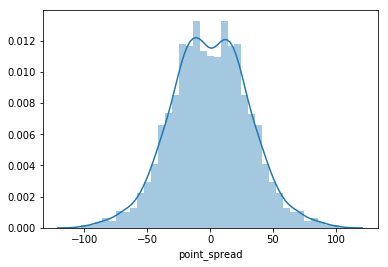

Point spread modes: [-2.5, 2.5]


In [7]:
# Distribution of point spreads

match_df = df[df['oppo_team'] != '0']

sns.distplot(match_df['point_spread'])
plt.show()

print('Point spread modes: {}'.format(list(match_df['point_spread'].mode())))

In [ ]:
# Creating betting DF with betting-odds predictions

betting_df = match_df.copy().assign(pred_win=betting_pred_win)
betting_df.loc[:, 'correct_pred'] = correct_pred(betting_df)

betting_df

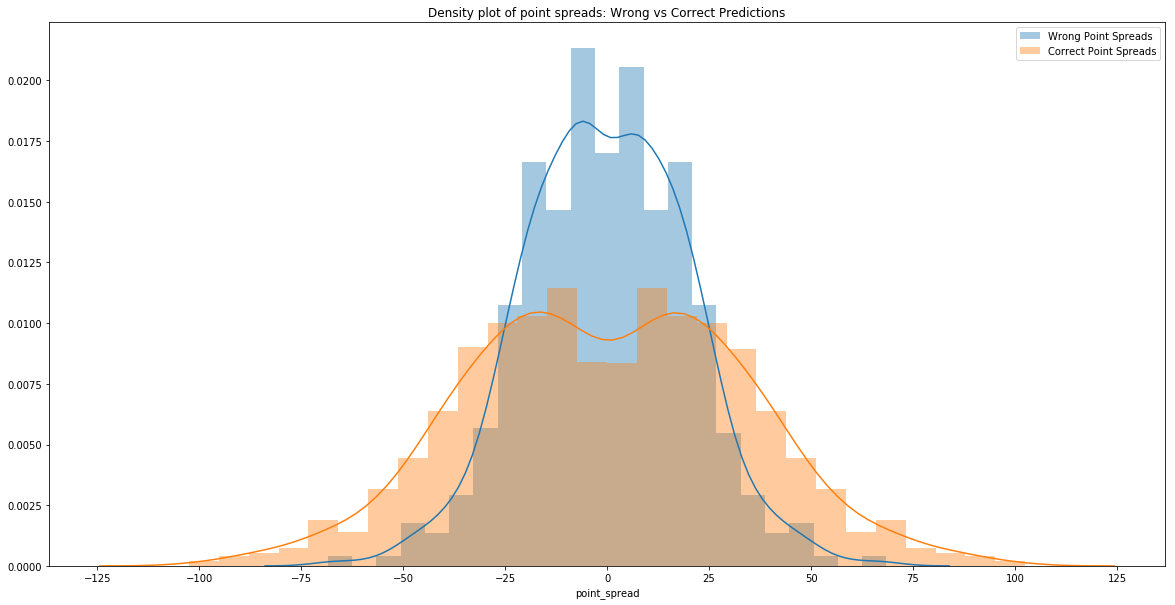

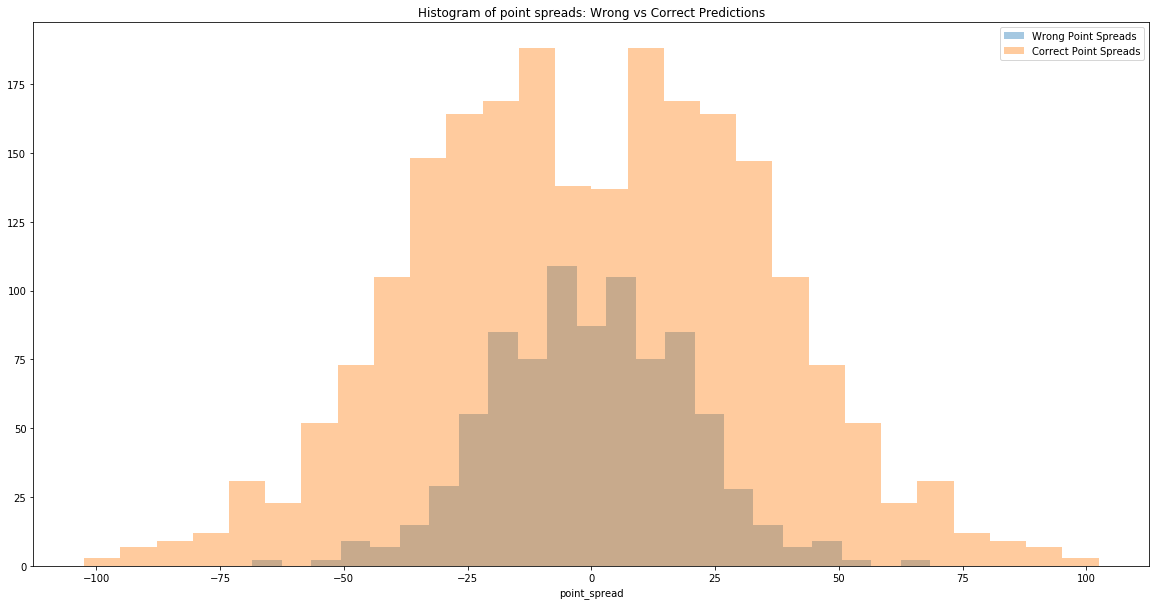

In [39]:
# When betting odds are wrong vs when they're correct

# Kernel Density Estimate + Normed Histogram
plt.figure(figsize=(15,5))
plt.xticks(np.linspace(-125, 125, num=11))

sns.distplot(betting_df[betting_df['correct_pred'] == 0]['point_spread'], label='Wrong Point Spreads')
sns.distplot(betting_df[betting_df['correct_pred'] == 1]['point_spread'], label='Correct Point Spreads')

plt.title('Density plot of point spreads: Wrong vs Correct Predictions')
plt.legend()
plt.show()

# Histogram
plt.figure(figsize=(15,5))
plt.xticks(np.linspace(-125, 125, num=11))

sns.distplot(betting_df[betting_df['correct_pred'] == 0]['point_spread'], label='Wrong Point Spreads', kde=False)
sns.distplot(betting_df[betting_df['correct_pred'] == 1]['point_spread'], label='Correct Point Spreads', kde=False)

plt.title('Histogram of point spreads: Wrong vs Correct Predictions')
plt.legend()
plt.show()

Betting odds are disproportionately wrong when the spread is small (roughly < abs(25) points). No surprise there. However, betting odds are correct more often than wrong at every point spread value.

### Betting Odds for Home Teams

As we've shown, all other things being equal, home teams win slightly more often (~57%) than visiting teams. So, how do the odds-makers take this into account? Do they have any biases with regards to home teams vs visiting teams?

As shown in the histogram below, there is a noticeable tendency to favour home teams, but it is unclear to what extent this is in line with home teams' real advantage over visitors.

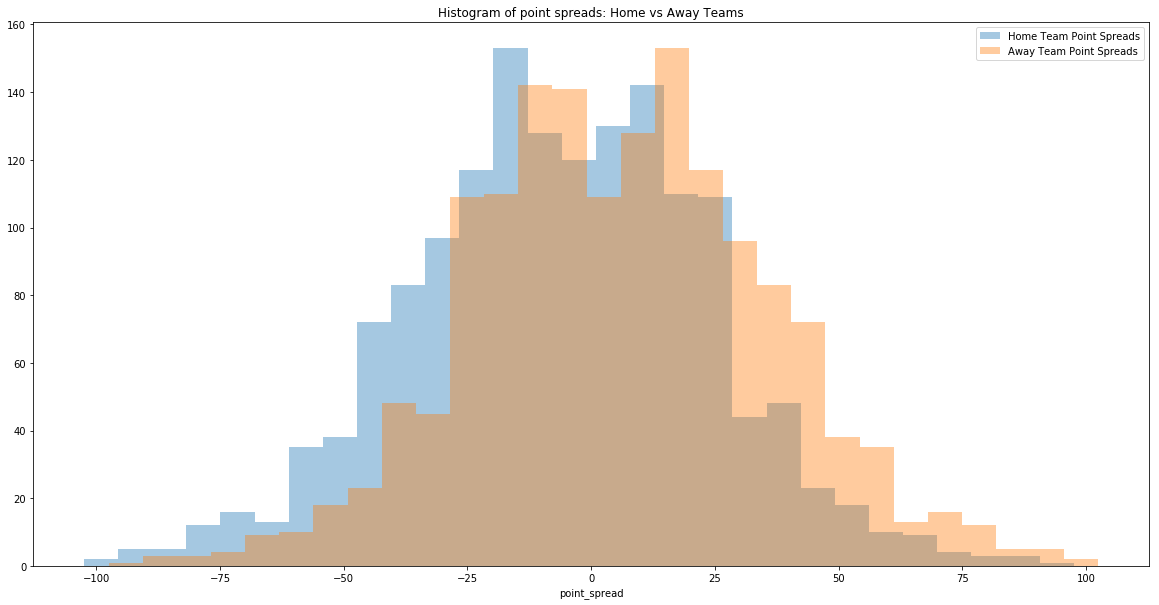

In [11]:
# Histogram: Home vs Away

home_bet_df = betting_df[betting_df['home_team'] == 1]

plt.figure(figsize=(15,5))
plt.xticks(np.linspace(-125, 125, num=11))

sns.distplot(home_bet_df['point_spread'], label='Home Team Point Spreads', kde=False)
sns.distplot(betting_df[betting_df['home_team'] == 0]['point_spread'], label='Away Team Point Spreads', kde=False)

plt.title('Histogram of point spreads: Home vs Away Teams')
plt.legend()
plt.show()

% Home Team is the favourite: 57.10%
Betting Accuracy for Home Teams: 72.39%


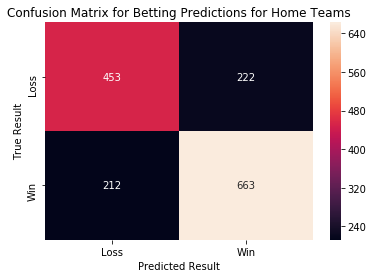

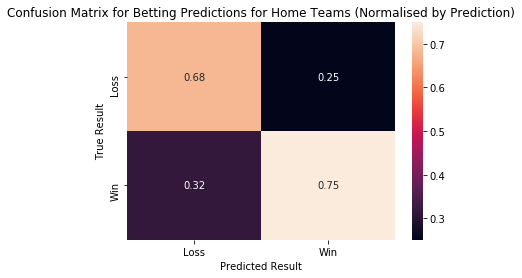

In [12]:
# Betting on home teams

home_fave_rate = home_bet_df['pred_win'].mean()
home_fave_accuracy = home_bet_df['correct_pred'].mean()

print('% Home Team is the favourite: {0:.2f}%'.format(home_fave_rate * 100))
print('Betting Accuracy for Home Teams: {0:.2f}%'.format(home_fave_accuracy * 100))

home_cm = confusion_matrix(home_bet_df['win'], home_bet_df['pred_win'])
normal_home_cm = home_cm.astype('float') / home_cm.sum(axis=0)[np.newaxis, :]

sns.heatmap(home_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Home Teams')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

sns.heatmap(home_cm.astype('float') / home_cm.sum(axis=0)[np.newaxis, :], annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Home Teams (Normalised by Prediction)')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

Odds-makers are reasonably balanced in favouring home teams, picking them to win 57.1% of the time, which is in line with the home teams' 57.29% win rate. The odds-makers improve upon their overall accuracy by about 3% when picking the home team, suggesting that they're better at recognising when home-field advantage will be a deciding factor than when it won't.

Beyond the widely-accepted impact of home-field advantage across sports and leagues, a quirk of the AFL's origins adds a wrinkle to our analysis. Aussie rules football began as a regional sport in the country's south and west, with rugby league being the dominant contact sport in the north and east. In fact, the Australian Football League began as the Victorian Football League, and even now 10 of the league's 18 teams reside in the state of Victoria, their home stadiums little more than an hour's drive (1 hour, 2 minutes according to [Google Maps](https://www.google.com/maps/dir/MCG,+Brunton+Avenue,+Richmond+VIC/GMHBA+Stadium,+370+Moorabool+St,+South+Geelong+VIC+3220/@-37.9887757,144.5273674,11z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x6ad64295571a6281:0x63575fd647a0b2f9!2m2!1d144.9834493!2d-37.8199669!1m5!1m1!1s0x6ad4140d007cc031:0x54b5f173afaf1677!2m2!1d144.3545702!2d-38.1579763!3e0)) away from each other. So, the conventional wisdom about home field advantage, based on various conversations that I've had, is that it is minor for teams from the same area and much more significant when the teams are from different states.

In [13]:
# Home vs Away, In-state vs Out-of-state

team_states_dict = {
    'Adelaide': 'SA',
    'Brisbane': 'QLD',
    'Carlton': 'VIC',
    'Collingwood': 'VIC',
    'Essendon': 'VIC',
    'Fitzroy': 'VIC',
    'Fremantle': 'WA',
    'GWS': 'NSW',
    'Geelong': 'VIC',
    'Gold Coast': 'QLD',
    'Hawthorn': 'VIC',
    'Melbourne': 'VIC',
    'North Melbourne': 'VIC',
    'Port Adelaide': 'SA',
    'Richmond': 'VIC',
    'South Melbourne': 'VIC',
    'St Kilda': 'VIC',
    'Sydney': 'NSW',
    'West Coast': 'WA',
    'Western Bulldogs': 'VIC',
    '0': '0'
}
# Adding venue states instead of just using team states, because sometimes matches are held
# in random places like Hobart, where no one has a real home-field advantage
venue_states_dict = {
    'Domain Stadium': 'WA',
    'AAMI Stadium': 'SA',
    'MCG': 'VIC',
    'Etihad Stadium': 'VIC',
    'Aurora Stadium': 'TAS',
    'Gabba': 'QLD',
    '0': '0',
    'GMHBA Stadium': 'VIC',
    'Metricon Stadium': 'QLD',
    'SCG': 'NSW',
    'Spotless Stadium': 'NSW',
    'Adelaide Oval': 'SA',
    'Blundstone Arena': 'TAS',
    'TIO Stadium': 'NT',
    'Westpac Stadium': 'NZ',
    'UTAS Stadium': 'TAS',
    'ANZ Stadium': 'NSW',
    'Blacktown International': 'NSW',
    'Manuka Oval': 'ACT',
    "Cazaly's Stadium": 'QLD',
    'Jiangwan Stadium': 'CH',
    'Mars Stadium': 'VIC'
}

geo_home_df = (betting_df.assign(team_state=betting_df['team'].apply(lambda x: team_states_dict[x]),
                                 oppo_team_state=betting_df['oppo_team'].apply(lambda x: team_states_dict[x]),
                                 venue_state=betting_df['venue'].apply(lambda x: venue_states_dict[x]))
                         .rename(columns={'pred_win': 'bet_pred_win'}))
geo_home_df.loc[:, 'cross_state_match'] = ((geo_home_df['team_state'] != geo_home_df['oppo_team_state']) &
                                           (geo_home_df['team_state'] == geo_home_df['venue_state'])).astype('int')
geo_home_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                 2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

Home team win rate for cross-state matches: 58.16%
% Home team is the favourite for cross-state matches: 60.86%
Betting accuracy for home teams for cross-state matches: 72.65%


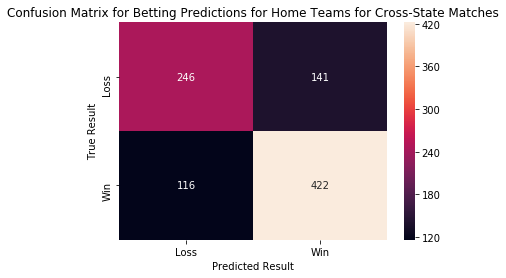

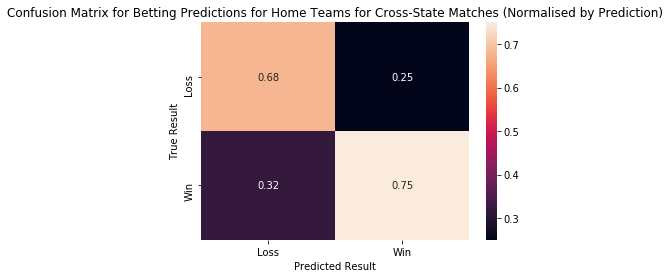

In [14]:
# Home team win % for cross-state matches

cross_state_home_df = geo_home_df[(geo_home_df['cross_state_match'] == 1) & geo_home_df['home_team'] == 1]
cross_home_win_rate = cross_state_home_df['win'].mean()
cross_home_fave_rate = cross_state_home_df['bet_pred_win'].mean()
cross_home_fave_accuracy = cross_state_home_df['correct_pred'].mean()

print('Home team win rate for cross-state matches: {0:.2f}%'.format(cross_home_win_rate * 100))
print('% Home team is the favourite for cross-state matches: {0:.2f}%'.format(cross_home_fave_rate * 100))
print('Betting accuracy for home teams for cross-state matches: {0:.2f}%'.format(cross_home_fave_accuracy * 100))

cross_home_cm = confusion_matrix(cross_state_home_df['win'], cross_state_home_df['bet_pred_win'])
normal_home_cm = cross_home_cm.astype('float') / cross_home_cm.sum(axis=0)[np.newaxis, :]

sns.heatmap(cross_home_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Home Teams for Cross-State Matches')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

sns.heatmap(cross_home_cm.astype('float') / cross_home_cm.sum(axis=0)[np.newaxis, :], annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Home Teams for Cross-State Matches (Normalised by Prediction)')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

This is evidence that betting odds tend to amplify conventional wisdom about the factors that contribute to teams' winning. Home teams do win cross-state matches about 1% more often than home teams overall, but odds-makers favour them 3% more often. The overall accuracy of betting odds is less than 1% higher, and the accuracy by predicted result is also about the same.

### Betting Odds for Higher-Ranked Teams

A stronger predictor of win probability than whether a team is playing at home is whether they are higher on the ladder than their opponent. As one would expect from looking at the odds-makers' approach to home teams, the histogram below shows an even stronger tendency to favour higher-ranked teams.

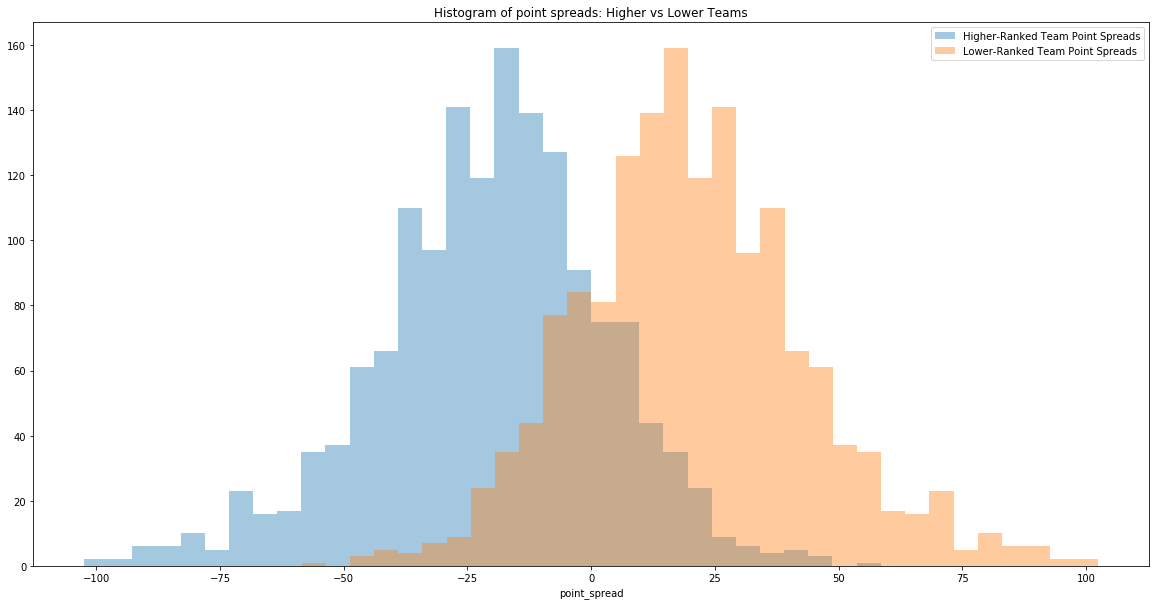

In [15]:
# Histogram: Higher vs Lower Ranked

high_rank_bet_df = betting_df[betting_df['ladder_rank'] < betting_df['oppo_ladder_rank']]

plt.figure(figsize=(15,5))
plt.xticks(np.linspace(-125, 125, num=11))

sns.distplot(high_rank_bet_df['point_spread'], label='Higher-Ranked Team Point Spreads', kde=False)
sns.distplot(betting_df[betting_df['ladder_rank'] > betting_df['oppo_ladder_rank']]['point_spread'], label='Lower-Ranked Team Point Spreads', kde=False)

plt.title('Histogram of point spreads: Higher vs Lower Teams')
plt.legend()
plt.show()

As with home teams, the question is now to what extent this tendency is backed up by the actual performance of higher-ranked teams.

% Higher-Ranked Team is the favourite: 81.87%
Betting Accuracy for Higher-Ranked Teams: 72.19%


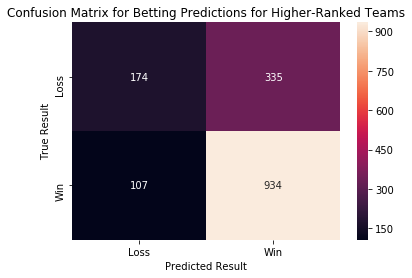

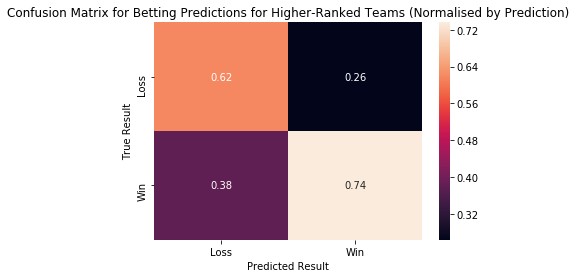

In [16]:
# Betting on higher-ranked teams

high_rank_fave_rate = high_rank_bet_df['pred_win'].sum() / len(high_rank_bet_df)
high_rank_fave_accuracy = high_rank_bet_df['correct_pred'].sum() / len(high_rank_bet_df)

print('% Higher-Ranked Team is the favourite: {0:.2f}%'.format(high_rank_fave_rate * 100))
print('Betting Accuracy for Higher-Ranked Teams: {0:.2f}%'.format(high_rank_fave_accuracy * 100))

rank_cm = confusion_matrix(high_rank_bet_df['win'], high_rank_bet_df['pred_win'])

sns.heatmap(rank_cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Higher-Ranked Teams')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

sns.heatmap(rank_cm.astype('float') / rank_cm.sum(axis=0)[np.newaxis, :], annot=True, xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix for Betting Predictions for Higher-Ranked Teams (Normalised by Prediction)')
plt.ylabel('True Result')
plt.xlabel('Predicted Result')
plt.show()

As with other segments, the odds-makers are consistent in their overall accuracy when looking at teams' respective positions on the ladder. The difference here is that the imbalance in favouring higher-ranked teams over lower-ranked teams is much greater than it is for favouring home teams over visiting teams. Higher-ranked teams only win 67.58% of their matches, but odds-makers pick them to win 81.87% of the time.

Looking at the confusion matrices, we see that betting odds incorrectly favour the higher-ranked team more often than they favour the lower-ranked team at all. Furthermore, as with picking the home team, only more so, odds-makers are significantly better at identifying when a better team (per their rank) will win than when a worse team will win.

It seems that the stronger the real effect is (home-field advantage, home-field advantage for cross-state matches, ladder rank as a predictor of wins) the more imbalanced betting odds become in favouring the teams that are supposed to win. Even if these biases don't seem to significantly affect the overall accuracy of betting odds, they do show some situations in which those odds are less accurate, namely when they are contrary to the conventional wisdom as to which teams should usually win.

### Betting Odds by Team

The AFL is closer to American sports leagues than European soccer leagues in how it is organised: There is a draft before each season begins where bad teams get first dibs on the top amateur players, there's a salary cap, teams sometimes move to different cities, etc. These rules are meant to promote parity and prevent a situation where the same teams are going to the finals and the same teams are languishing at the bottom of the ladder year after year. Despite this, in talking to footy fans, I get the sense that some teams get a reputation for being perennial winners or losers, and these perceptions are slow to change. Do these team-based biases show up in the betting odds? 

In [17]:
# Group by teams

team_bet_df = (betting_df.groupby(level=0)[['win', 'pred_win', 'correct_pred']]
                         .mean()
                         .rename(columns={'win': 'win_rate', 'pred_win': 'pred_win_rate',
                                          'correct_pred': 'correct_pred_rate'}))
team_bet_df.loc[:, 'pred_win_diff'] = (team_bet_df['pred_win_rate'] - team_bet_df['win_rate'])

team_bet_df.sort_values('pred_win_diff')

,win_rate,pred_win_rate,correct_pred_rate,pred_win_diff
team,,,,
Brisbane,0.284091,0.193182,0.738636,-0.090909
Melbourne,0.312500,0.267045,0.710227,-0.045455
Essendon,0.431818,0.392045,0.693182,-0.039773
Gold Coast,0.259740,0.220779,0.818182,-0.038961
St Kilda,0.437500,0.403409,0.750000,-0.034091
Fremantle,0.551136,0.517045,0.761364,-0.034091
Richmond,0.505682,0.477273,0.681818,-0.028409
North Melbourne,0.511364,0.494318,0.721591,-0.017045
Western Bulldogs,0.471591,0.471591,0.738636,0.000000


As represented by the percent difference between the win rate and predicted win rate, there does seem to be a tendency to over-favour teams with winning records and under-favour teams with losing records. However, this doesn't seem to correlate with the accuracy of betting predictions, at least not linearly. Rather, the betting odds are relatively accurate for bad and good teams, and inaccurate for the mediocre teams.

In [18]:
# Group by team and year to get more data points

team_year_bet_df = (betting_df.groupby(level=[0, 1])
                         [['win', 'pred_win', 'correct_pred']]
                         .mean()
                         .rename(columns={'win': 'win_rate', 'pred_win': 'pred_win_rate',
                                          'correct_pred': 'correct_pred_rate'})
                         .sort_values('correct_pred_rate'))
team_year_bet_df.loc[:, 'pred_win_diff'] = team_year_bet_df['pred_win_rate'] - team_year_bet_df['win_rate']

team_year_bet_df

,,win_rate,pred_win_rate,correct_pred_rate,pred_win_diff
team,year,,,,
Richmond,2015,0.681818,0.727273,0.500000,0.045455
Hawthorn,2017,0.454545,0.409091,0.500000,-0.045455
Port Adelaide,2010,0.454545,0.318182,0.500000,-0.136364
Brisbane,2010,0.318182,0.363636,0.500000,0.045455
Collingwood,2017,0.409091,0.409091,0.545455,0.000000
Essendon,2010,0.318182,0.227273,0.545455,-0.090909
Sydney,2011,0.545455,0.545455,0.545455,0.000000
Fremantle,2010,0.590909,0.500000,0.545455,-0.090909
West Coast,2017,0.545455,0.727273,0.545455,0.181818


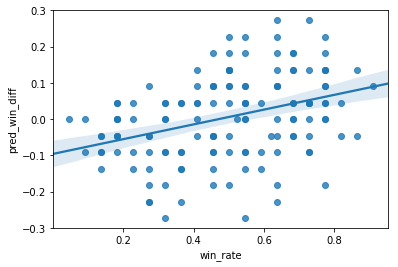

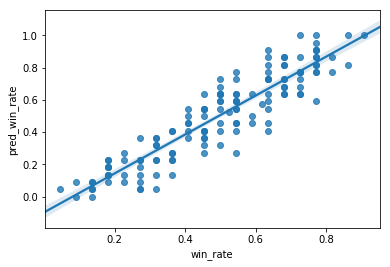

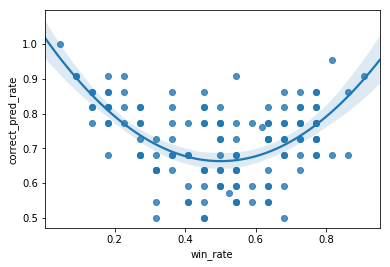

In [19]:
# Scatter plots for team-based win rates

sns.regplot(x='win_rate', y='pred_win_diff', data=team_year_bet_df.reset_index())
plt.show()

sns.regplot(x='win_rate', y='pred_win_rate', data=team_year_bet_df.reset_index())
plt.show()

sns.regplot(x='win_rate', y='correct_pred_rate', data=team_year_bet_df.reset_index(), order=2)
plt.show()

The relationship between teams' win rates and odds-makers' tendency to over-favour good teams and under-favour bad teams exists but is weak. It's certainly overwhelmed by the much stronger relationship between teams' win rate and their predicted win rate per betting odds, meaning that the pro-good-team bias doesn't significantly impact the accuracy of betting odds.

The direct relationship between win rate and the accuracy of betting odds is more interesting, as it shows that odds-makers are better at predicting results for bad teams and good teams, but have trouble with the mediocre teams that win between 40% and 60% of their matches.